In [1]:
%cd ..

/home/tkts0426/git/JAFEE_2022_winter/program


In [2]:
import esig
import esig.tosig as ts
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import math
import warnings
import matplotlib.patches as mpatches

from sklearn.preprocessing import MinMaxScaler
from torch import optim
from tqdm import tqdm
from sklearn import utils
# 自作ライブラリー・関数
from src.cvae import CVAE
from src.vae import VAE
from src.create_dataset import MyDataset
from src.custom_loss import CustomLoss
from src.utils import tosig
from src.utils.leadlag import leadlag
from src import logsig_inversion
from src import logsig_inversion_v2
from src import process_discriminator
from src.sig_calculus_func import Lead, Lag

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

warnings.simplefilter('ignore')

In [3]:
def generate(cond, input_dim, n_latent, n_samples = None):
    if n_samples is not None:
        randoms = []
        for i in range(n_samples):
            random = np.random.normal(0, 1, size=(1, n_latent))
            randoms.append(random)
    else:
        randoms = np.random.normal(0, 1, size=(1, n_latent))
        cond = torch.Tensor(cond)
    
    randoms = torch.Tensor(randoms).reshape(-1, n_latent)
    cond = torch.Tensor(cond.float()).reshape(-1, input_dim)
    
    samples = generator.decoder(randoms, cond)
    
    return samples

# Download the data

In [4]:
DATAs = np.load('Data/DATAs_1000.npy')

# Create the leadlag data

In [5]:
leadlag_DATAs = []
for i in range(DATAs.shape[0]):
    timestamp = DATAs[i, :, 0]
    price = DATAs[i, :, 1] - DATAs[i, 0, 1]
    vol = DATAs[i, :, 2] - DATAs[i, 0, 2]
    spot_vol = DATAs[i, :, 3] - DATAs[i, 0, 3]

    leadlag_timestamp = leadlag(timestamp)
    leadlag_price = leadlag(price)
    leadlag_vol = leadlag(vol)
    leadlag_spot_vol = leadlag(spot_vol)

    leadlag_DATA = np.c_[leadlag_timestamp, leadlag_price, leadlag_vol, leadlag_spot_vol]
    leadlag_DATAs.append(leadlag_DATA)

leadlag_DATAs = np.array(leadlag_DATAs)

# Make the explanatory variable

In [27]:
sig_order = 4
exp_col = [2, 3, 6, 7]

In [28]:
orig_logsig = []
for i in tqdm(range(leadlag_DATAs.shape[0]), desc="Computing log-signatures"):
    path = leadlag_DATAs[i, :, :]
    
    orig_logsig.append(esig.stream2logsig(path[:, exp_col], sig_order))
    
orig_logsig = np.array(orig_logsig)

scaler = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig = scaler.fit_transform(orig_logsig)

logsigs = logsig[1:]
conditions = logsig[:-1]

data = utils.as_float_array(logsigs)
data_cond = utils.as_float_array(conditions)

input_dim = data.shape[1]
cond_dim = data_cond.shape[1]

Computing log-signatures: 100%|███████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2245.47it/s]


In [29]:
log_sig_keys = esig.logsigkeys(len(exp_col), sig_order)
print(log_sig_keys) 

 1 2 3 4 [1,2] [1,3] [1,4] [2,3] [2,4] [3,4] [1,[1,2]] [1,[1,3]] [1,[1,4]] [2,[1,2]] [2,[1,3]] [2,[1,4]] [2,[2,3]] [2,[2,4]] [3,[1,2]] [3,[1,3]] [3,[1,4]] [3,[2,3]] [3,[2,4]] [3,[3,4]] [4,[1,2]] [4,[1,3]] [4,[1,4]] [4,[2,3]] [4,[2,4]] [4,[3,4]] [1,[1,[1,2]]] [1,[1,[1,3]]] [1,[1,[1,4]]] [2,[1,[1,2]]] [2,[1,[1,3]]] [2,[1,[1,4]]] [2,[2,[1,2]]] [2,[2,[1,3]]] [2,[2,[1,4]]] [2,[2,[2,3]]] [2,[2,[2,4]]] [3,[1,[1,2]]] [3,[1,[1,3]]] [3,[1,[1,4]]] [3,[2,[1,2]]] [3,[2,[1,3]]] [3,[2,[1,4]]] [3,[2,[2,3]]] [3,[2,[2,4]]] [3,[3,[1,2]]] [3,[3,[1,3]]] [3,[3,[1,4]]] [3,[3,[2,3]]] [3,[3,[2,4]]] [3,[3,[3,4]]] [4,[1,[1,2]]] [4,[1,[1,3]]] [4,[1,[1,4]]] [4,[2,[1,2]]] [4,[2,[1,3]]] [4,[2,[1,4]]] [4,[2,[2,3]]] [4,[2,[2,4]]] [4,[3,[1,2]]] [4,[3,[1,3]]] [4,[3,[1,4]]] [4,[3,[2,3]]] [4,[3,[2,4]]] [4,[3,[3,4]]] [4,[4,[1,2]]] [4,[4,[1,3]]] [4,[4,[1,4]]] [4,[4,[2,3]]] [4,[4,[2,4]]] [4,[4,[3,4]]] [[1,2],[1,3]] [[1,2],[1,4]] [[1,2],[2,3]] [[1,2],[2,4]] [[1,2],[3,4]] [[1,3],[1,4]] [[1,3],[2,3]] [[1,3],[2,4]] [[1,3],[3,4]]

# Make the target variable

In [30]:
target_col = [2, 3, 4, 5]

In [31]:
orig_logsig_target = []
for i in tqdm(range(leadlag_DATAs.shape[0]), desc="Computing log-signatures"):
    path = leadlag_DATAs[i, :, :]
    
    orig_logsig_target.append(esig.stream2logsig(path[:, target_col], sig_order))
    
orig_logsig_target = np.array(orig_logsig_target)

scaler = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig_target = scaler.fit_transform(orig_logsig_target)

target_data = utils.as_float_array(logsig_target)

input_dim_target = target_data.shape[1]

Computing log-signatures: 100%|███████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2284.84it/s]


In [32]:
log_sig_keys = esig.logsigkeys(len(target_col), sig_order)
print(log_sig_keys) 

 1 2 3 4 [1,2] [1,3] [1,4] [2,3] [2,4] [3,4] [1,[1,2]] [1,[1,3]] [1,[1,4]] [2,[1,2]] [2,[1,3]] [2,[1,4]] [2,[2,3]] [2,[2,4]] [3,[1,2]] [3,[1,3]] [3,[1,4]] [3,[2,3]] [3,[2,4]] [3,[3,4]] [4,[1,2]] [4,[1,3]] [4,[1,4]] [4,[2,3]] [4,[2,4]] [4,[3,4]] [1,[1,[1,2]]] [1,[1,[1,3]]] [1,[1,[1,4]]] [2,[1,[1,2]]] [2,[1,[1,3]]] [2,[1,[1,4]]] [2,[2,[1,2]]] [2,[2,[1,3]]] [2,[2,[1,4]]] [2,[2,[2,3]]] [2,[2,[2,4]]] [3,[1,[1,2]]] [3,[1,[1,3]]] [3,[1,[1,4]]] [3,[2,[1,2]]] [3,[2,[1,3]]] [3,[2,[1,4]]] [3,[2,[2,3]]] [3,[2,[2,4]]] [3,[3,[1,2]]] [3,[3,[1,3]]] [3,[3,[1,4]]] [3,[3,[2,3]]] [3,[3,[2,4]]] [3,[3,[3,4]]] [4,[1,[1,2]]] [4,[1,[1,3]]] [4,[1,[1,4]]] [4,[2,[1,2]]] [4,[2,[1,3]]] [4,[2,[1,4]]] [4,[2,[2,3]]] [4,[2,[2,4]]] [4,[3,[1,2]]] [4,[3,[1,3]]] [4,[3,[1,4]]] [4,[3,[2,3]]] [4,[3,[2,4]]] [4,[3,[3,4]]] [4,[4,[1,2]]] [4,[4,[1,3]]] [4,[4,[1,4]]] [4,[4,[2,3]]] [4,[4,[2,4]]] [4,[4,[3,4]]] [[1,2],[1,3]] [[1,2],[1,4]] [[1,2],[2,3]] [[1,2],[2,4]] [[1,2],[3,4]] [[1,3],[1,4]] [[1,3],[2,3]] [[1,3],[2,4]] [[1,3],[3,4]]

# Make the dataset

In [33]:
dataset = MyDataset(data, data_cond, target_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)

# Train

In [34]:
n_epochs = 1000
learning_rate=0.005

input_dim = input_dim
input_dim_target = input_dim_target
n_latent = 10

In [35]:
generator = CVAE(input_dim = input_dim, cond_dim = cond_dim, input_dim_target = input_dim_target, n_latent = n_latent, alpha=0.003)

criterion = CustomLoss()
optimizer = optim.SGD(generator.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.005)

In [36]:
for i in range(n_epochs):
    loss_sum = 0
    for _, (inputs, target) in enumerate(dataloader):
        data = inputs[0]
        cond = inputs[1]
        
        optimizer.zero_grad()
        
        mn, sd, sample_z, output = generator(data, cond)
        
        loss = criterion(mn = mn, sd = sd, outputs = output, targets = target, alpha = 0.003)
        loss.backward()
        
        optimizer.step()
        
        loss_sum += loss
    
    if i % 10 == 0:
        print(loss_sum / len(dataloader))

tensor(1.3087, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.5741, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.5560, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.5352, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.5056, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.4757, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.4524, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.4372, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.4285, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.4238, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.4199, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.4180, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.4154, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.4140, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.4120, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.4113, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.4091, dtype=torch.float64, grad

# Generate the process

In [37]:
# Pip size
price_pip = 0.01
spot_vol_pip = 0.0000045

# Number of pips for search space
price_n_pips = 100
spot_vol_n_pips = 1000 
# Number of points
n_points = 100

n_iterations = 50
n_organisms = 100

In [38]:
generated_path = []
generated_logsigs = []
for cond in data_cond[:100]:
    generated_logsig = generate(cond, cond_dim, n_latent).to('cpu').detach().numpy().copy()
    recovered_path, loss = logsig_inversion_v2.train(generated_logsig, sig_order, n_iterations, n_organisms, n_points, price_pip, spot_vol_pip, price_n_pips, spot_vol_n_pips)
    
    generated_path.append(recovered_path)
    generated_logsigs.append(generated_logsig)

In [39]:
sigs1 = []
for i, path in enumerate(generated_path):
    path_sig = esig.stream2sig(leadlag(path), sig_order)
    sigs1.append(path_sig)
sigs1 = np.array(sigs1)
    
sigs2 = []
for i in range(100):
    path = leadlag_DATAs[i][:, [4, 5]]
    path_sig = esig.stream2sig(path, sig_order)
    sigs2.append(path_sig)
sigs2 = np.array(sigs2)

In [40]:
res = process_discriminator.test(sigs1, sigs2, order=sig_order, compute_sigs=False, confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))


Are the generated and real distributions DIFFERENT? False


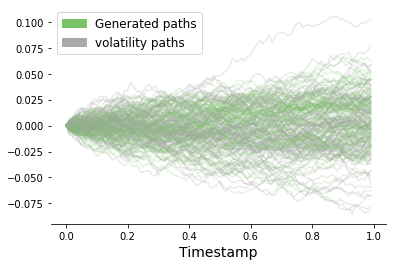

In [41]:
fig, ax = plt.subplots()
for path1, path2 in zip(DATAs[:100], generated_path):
    vol_path = path1[:, 2] -  path1[0, 2]
    ax.plot(vol_path, 'darkgray', alpha=0.25)

    ax.plot(path2, '#79c266', alpha=0.2)

gray_patch = mpatches.Patch(color = 'darkgray', label = 'volatility paths')
green_patch = mpatches.Patch(color = '#79c266', label = 'Generated paths')

x = range(0, 101, 20)
ax.set_xticks(x)
ax.set_xticklabels([str(i/100) for i in x])
ax.set_xlabel("Timestamp", fontsize=14)

plt.legend(handles=[green_patch, gray_patch], fontsize=12)    
#外枠の削除
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)

fig.savefig("Figures/generatedVolFromPriceSpot_{}.png".format(sig_order), dpi=300, bbox_inches="tight")
plt.show();

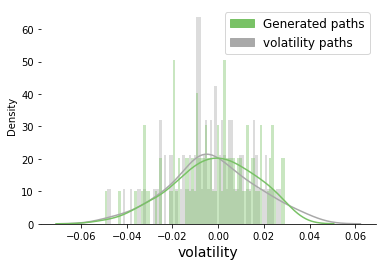

In [42]:
generated_vol = [path[40] for path in generated_path]
real_vol = [path[40, 2] - path[0, 2] for path in DATAs[:100]]

# 最小値
x_min_gene = min(generated_vol)
x_min_real = min(real_vol)

x_min = min(x_min_gene, x_min_real)

# 最大値
x_max_gene = max(generated_vol)
x_max_real = max(real_vol)

x_max = min(x_max_gene, x_max_real)

# 最小値から最大値の範囲で5間隔
range_bin_width = np.arange(x_min, x_max, 0.001)

fig, ax = plt.subplots()
ax = sns.distplot(real_vol, color = 'darkgray', bins=range_bin_width, label="Real paths", kde = True)
ax = sns.distplot(generated_vol, color = '#79c266', bins=range_bin_width, label="Generated paths", kde = True)


#外枠の削除
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)

plt.xlabel("volatility", fontsize=14)
plt.legend(handles=[green_patch, gray_patch], fontsize=12)  
fig.savefig("Figures/generatedVolFromPriceSpot_40_{}.png".format(sig_order), dpi=300, bbox_inches="tight")
plt.show();